In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

In [42]:
from collections import OrderedDict

In [43]:
import numpy as np
import pandas as pd

In [44]:
from reflectorch import *

In [45]:
trainer = get_trainer_by_name('l2q256_absorption_1', load_weights=False)

Model l2q256_absorption_1 loaded. Number of parameters: 2.85 M


## Train on simulated data

In [46]:
training_data = trainer.loader.get_batch(1000)

In [47]:
training_data.keys()

dict_keys(['params', 'scaled_params', 'q_values', 'scaled_noisy_curves'])

##### Plot Params Distribution

In [48]:
slds = training_data['params'].slds
real_slds = []
imag_slds = []
for n in np.arange(slds.shape[0]):
    for m in np.arange(slds.shape[1]):
        r_slds = slds[n,m].cpu().numpy().real
        i_slds = slds[n,m].cpu().numpy().imag
        real_slds.append(r_slds)
        imag_slds.append(i_slds)

In [49]:
thicknesses = training_data['params'].thicknesses
thickness = []
for n in np.arange(thicknesses.shape[0]):
    for m in np.arange(thicknesses.shape[1]):
        t = thicknesses[n,m].cpu().numpy()
        thickness.append(t)

In [50]:
roughnesses = training_data['params'].roughnesses
roughness = []
for n in np.arange(roughnesses.shape[0]):
    for m in np.arange(roughnesses.shape[1]):
        r = roughnesses[n,m].cpu().numpy()
        roughness.append(r)

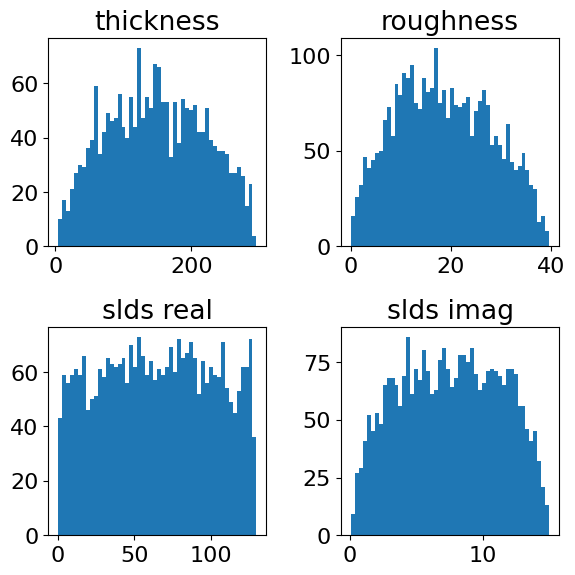

In [51]:
fig1, axs1 = plt.subplots(2,2, figsize=(6,6))
axs1[0,0].hist(thickness, bins=50)
axs1[0,0].set_title("thickness")
axs1[0,1].hist(roughness, bins=50)
axs1[0,1].set_title("roughness")
axs1[1,0].hist(real_slds, bins=50)
axs1[1,0].set_title("slds real")
axs1[1,1].hist(imag_slds, bins=50)
axs1[1,1].set_title("slds imag")
fig1.tight_layout(pad=1)


In [52]:
from reflectorch.extensions.jupyter import JPlotLoss

In [53]:
trainer.set_lr(1e-4)

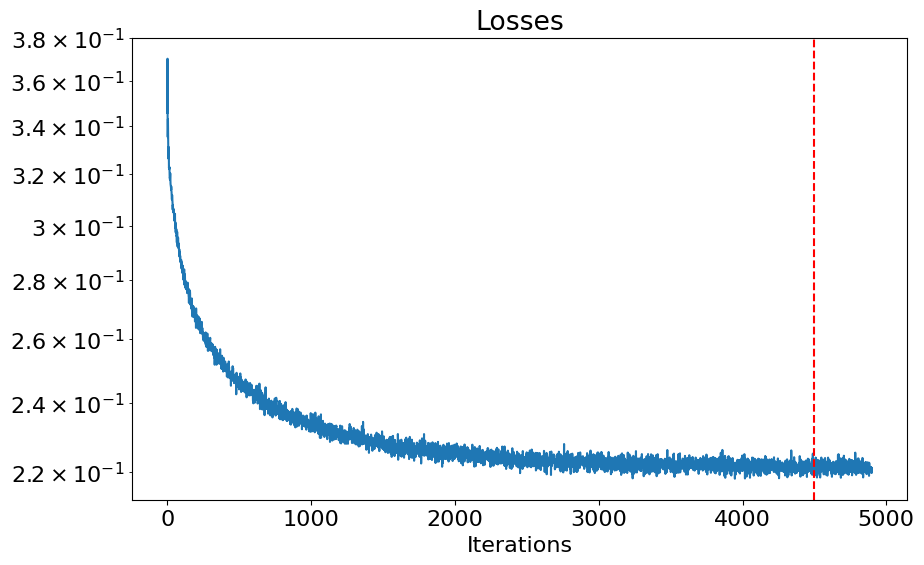

Loss = 2.21e-01: 100%|██████████| 5000/5000 [1:31:30<00:00,  1.10s/it]


In [54]:
trainer.train_epoch(5000, callbacks=(JPlotLoss(100, ), StepLR(100, 0.9, last_epoch=4000), SaveBestModel(str(SAVED_MODELS_DIR / 'l2q256_absorption_1.pt'), 100, )))

## Test on simulated Data

In [55]:
import torch

In [56]:
test_data = trainer.loader.get_batch(100)

In [57]:
scaled_target_params = trainer.loader.prior_sampler.scale_params(test_data['params'])

In [58]:
n = test_data['params'].num_params

In [59]:
scaled_params = scaled_target_params[..., :n]  # scaled target params
scaled_bounds = scaled_target_params[..., n:]  # scaled target bounds

In [60]:
noisy_curves = trainer.loader.curves_scaler.restore(test_data['scaled_noisy_curves'])
assert torch.allclose(test_data['scaled_noisy_curves'], trainer.loader.curves_scaler.scale(noisy_curves))

In [61]:
scaled_input = torch.cat([test_data['scaled_noisy_curves'], scaled_bounds], dim=-1)

In [62]:
test_data.keys()

dict_keys(['params', 'scaled_params', 'q_values', 'scaled_noisy_curves'])

In [63]:
with torch.no_grad():
    trainer.model.eval()
    scaled_predictions = trainer.model(scaled_input.float())

In [64]:
scaled_predictions = torch.cat([scaled_predictions, scaled_bounds], dim=-1)

In [65]:
restored_predictions = trainer.loader.prior_sampler.restore_params(scaled_predictions)

In [66]:
torch.allclose(restored_predictions.min_bounds, test_data['params'].min_bounds)

True

In [67]:
real_curves = test_data['params'].reflectivity(trainer.loader.q_generator.q)

In [68]:
predicted_curves = restored_predictions.reflectivity(trainer.loader.q_generator.q)

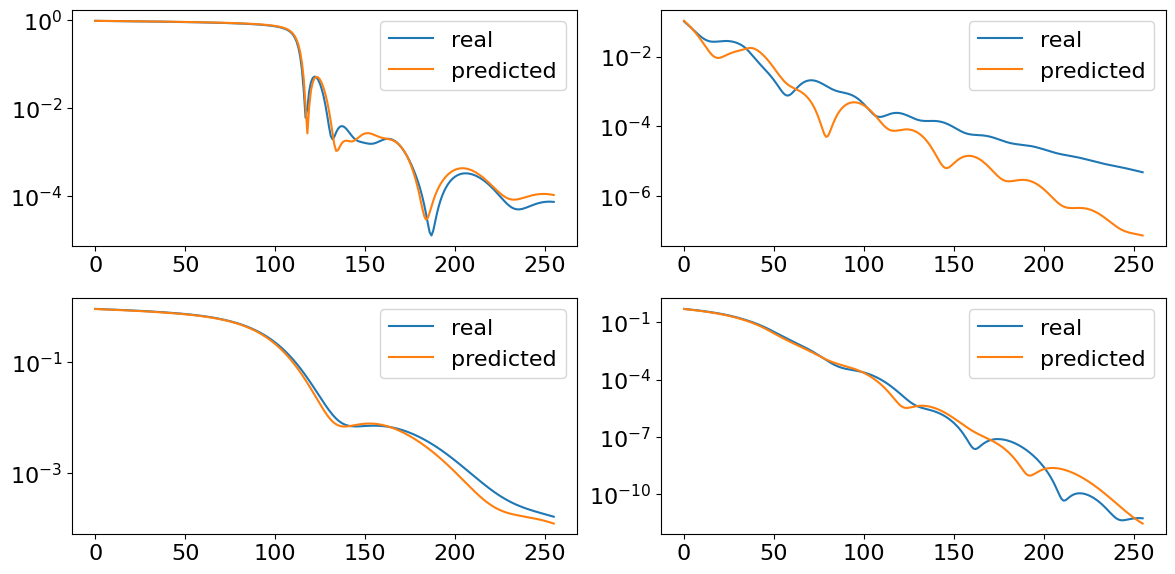

In [69]:
fig2, axs2 = plt.subplots(2,2, figsize=(12,6))
axs2[0,0].semilogy(real_curves[2].cpu().numpy(), label="real")
axs2[0,0].semilogy(predicted_curves[2].cpu().numpy(), label="predicted")
axs2[0,0].legend()
axs2[0,1].semilogy(real_curves[11].cpu().numpy(), label="real")
axs2[0,1].semilogy(predicted_curves[11].cpu().numpy(), label="predicted")
axs2[0,1].legend()
axs2[1,0].semilogy(real_curves[22].cpu().numpy(), label="real")
axs2[1,0].semilogy(predicted_curves[22].cpu().numpy(), label="predicted")
axs2[1,0].legend()
axs2[1,1].semilogy(real_curves[44].cpu().numpy(), label="real")
axs2[1,1].semilogy(predicted_curves[44].cpu().numpy(), label="predicted")
axs2[1,1].legend()
fig2.tight_layout(pad=1)


In [70]:
# Absolute errors
real_thick = test_data['params'].thicknesses
predict_thick = restored_predictions.thicknesses
abserr_thick = []

for j in np.arange(real_thick.shape[0]):
    for i in np.arange(real_thick.shape[1]):
        real = real_thick[j,i].cpu().numpy()
        predict = predict_thick[j,i].cpu().numpy()
        #abserr = np.absolute(real - predict)
        abserr = real - predict
        abserr_thick.append(abserr)

In [71]:
real_rough = test_data['params'].roughnesses
predict_rough = restored_predictions.roughnesses
abserr_rough = []

for j in np.arange(real_rough.shape[0]):
    for i in np.arange(real_rough.shape[1]):
        real = real_rough[j,i].cpu().numpy()
        predict = predict_rough[j,i].cpu().numpy()
        #abserr = np.absolute(real - predict)
        abserr = real - predict
        abserr_rough.append(abserr)

In [72]:
real_slds = test_data['params'].slds
predict_slds = restored_predictions.slds
abserr_slds_r = []
abserr_slds_i = []

for j in np.arange(real_slds.shape[0]):
    for i in np.arange(real_slds.shape[1]):
        real_r = real_slds[j,i].cpu().numpy().real
        real_i = real_slds[j,i].cpu().numpy().imag
        predict_r = predict_slds[j,i].cpu().numpy().real
        predict_i = predict_slds[j,i].cpu().numpy().imag
        #abserr_r = np.absolute(real_r - predict_r)
        abserr_r = real_r - predict_r
        #abserr_i = np.absolute(real_i - predict_i)
        abserr_i = real_i - predict_i
        abserr_slds_r.append(abserr_r)
        abserr_slds_i.append(abserr_i)

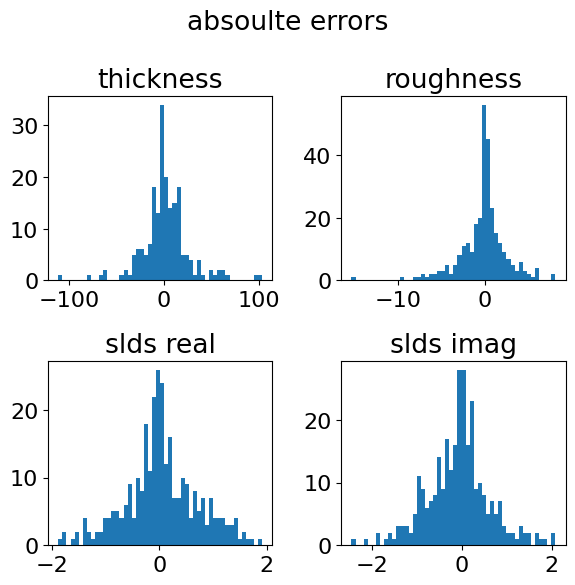

In [73]:
fig3, axs3 = plt.subplots(2,2, figsize=(6,6))
axs3[0,0].hist(abserr_thick, bins=50)
axs3[0,0].set_title("thickness")
axs3[0,1].hist(abserr_rough, bins=50)
axs3[0,1].set_title("roughness")
axs3[1,0].hist(abserr_slds_r, bins=50)
axs3[1,0].set_title("slds real")
axs3[1,1].hist(abserr_slds_i, bins=50)
axs3[1,1].set_title("slds imag")
fig3.suptitle("absoulte errors")
fig3.tight_layout(pad=1)


## Test on experimental Data

In [74]:
from reflectorch.inference.preprocess_exp import standard_preprocessing

In [75]:
class SpecParser:
    """Parse individual SPEC file scans on to Pandas DataFrames.

    Args:
    file_path: File path of the SPEC file.
    """

    def __init__(self, file_path: str):
        self.file_path = file_path
        with open(file_path) as file:
            self._file_lines = [line.rstrip() for line in file]

        self._scan_index = OrderedDict()
        self._index_scans()
        print(f'{self.number_of_scans} scans found in {file_path}')

    @property
    def scan_info(self):
        return self._scan_index

    @property
    def number_of_scans(self):
        return len(self._scan_index)

    def extract_scan(self, scan_number):
        """Extract scan of a given number into a table in the form of a Pandas :class:`DataFrame`."""
        column_names = self._extract_column_names(scan_number)
        data = self._extract_scan_data(scan_number)
        return pd.DataFrame(data=data, columns=column_names)

    def _extract_column_names(self, scan_number):
        header_idx = self._scan_index[int(scan_number)]['data_start_line']
        column_names = self._file_lines[header_idx].lstrip('#L ').split('  ')
        return column_names

    def _extract_scan_data(self, scan_number):
        data_idx = self._scan_index[int(scan_number)]['data_start_line'] + 1
        data = []
        while True:
            try:
                line = self._file_lines[data_idx]
            except IndexError:
                break
            else:
                if line.startswith('#') or not line:
                    break
            data.append(line.split())
            data_idx += 1
        return np.array(data, dtype=float)

    def _search_for_next_scan(self, start_index=0):
        index = start_index
        while True:
            try:
                line = self._file_lines[index]
            except IndexError:
                return None
            else:
                if line.startswith('#S'):
                    return index
            index += 1

    def _index_scans(self, start_index=0):
        start_index = self._search_for_next_scan(start_index)
        if start_index is None:
            return
        scan = {'scan_start_line': start_index}
        index = start_index
        while True:
            try:
                line = self._file_lines[index]
            except IndexError:
                scan['scan_end_line'] = index - 1
                break
            if line.startswith('#S'):
                line_parts = line.split()
                scan_number = line_parts[1]
                scan['spec_command'] = ' '.join(line_parts[2:])
            elif line.startswith('#D'):
                line_parts = line.split()
                scan['time'] = ' '.join(line_parts[1:])
            elif line.startswith('#L'):
                scan['data_start_line'] = index
            elif not line.strip():
                scan['scan_end_line'] = index - 1
                break
            index += 1
        self._scan_index[int(scan_number)] = scan
        self._index_scans(scan['scan_end_line'] + 1)

In [76]:
sp = SpecParser('2023-05-02-Ni_on_Si.spec')

61 scans found in 2023-05-02-Ni_on_Si.spec


In [77]:
scans = {}

for scan_num in (19, 26, 37, 46, 47, 54, 61):
    scans[scan_num] = sp.extract_scan(scan_num)

In [78]:
scan = scans[26]

In [79]:
skip_points = 25

double_theta = np.array(scan['Theta'] + scan['Two Theta'])[skip_points:]
r = np.array(scan['Specular'])[skip_points:]
ab = np.ones_like(r)

q_interp = np.linspace(0.02, 0.5, 256)

res = standard_preprocessing(
    r, double_theta, np.ones_like(r), wavelength=1., beam_width=0.5, sample_length=25, q_interp=q_interp
)

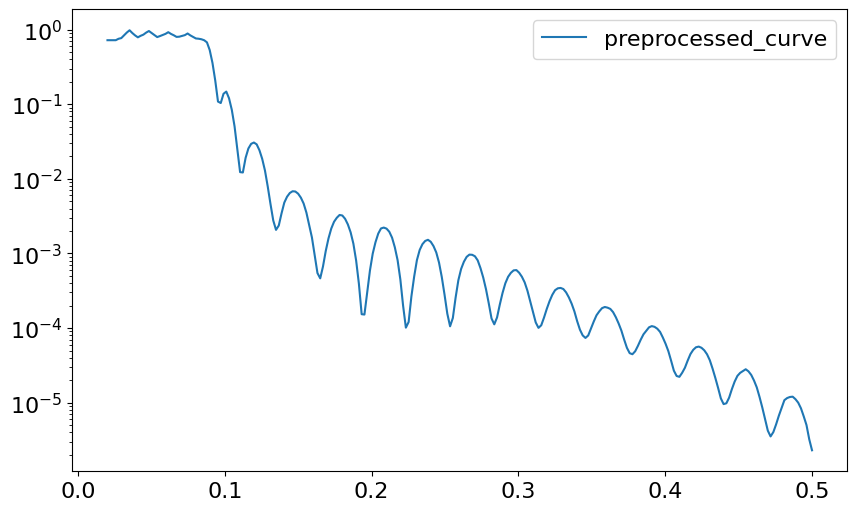

In [80]:
#plt.semilogy(res['q_values'], res['curve'], label='curve')
plt.semilogy(res['q_interp'], res['curve_interp'], label='preprocessed_curve')
plt.legend()